In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import scipy.integrate as spi
from scipy.optimize import curve_fit
import numpy as np
import matplotlib 
import optuna
import pickle as pkl  
np.set_printoptions(suppress=True)
plt.rc('text', usetex=True)

dataDir = "/home/polivares/Dropbox/DocUSM/Researches/InfluenzaMeningococcal/Data/"
imageDir = "/home/polivares/Dropbox/DocUSM/Researches/InfluenzaMeningococcal/Scripts/images/"

In [2]:
# Load data
fluSeries = pd.read_pickle(dataDir + "pkls/fluSeries.pkl")
ausPop = pd.read_pickle(dataDir + "pkls/ausPop.pkl")

In [ ]:
import os
if os.path.isfile(dataDir + "pkls/fluSIRParams.pkl"):
    fluParams = pkl.load(open(dataDir + "pkls/fluSIRParams.pkl", "rb"))
else:
    fluParams = {}

In [ ]:
# Evaluation time
from datetime import datetime # Library for datetime format
from dateutil import relativedelta # Library to calculate delta time from date

year = 2017
startdate = str(year) + '-01'
enddate = str(year) + '-12'


date_format = "%Y-%m"
sd = datetime.strptime(startdate, date_format)
ed = datetime.strptime(enddate, date_format)

n_months = relativedelta.relativedelta(ed, sd) # Number of months (delta time)
print(n_months)

In [ ]:
# Timestamp parameters
t_start = 0.0; t_end = n_months.months; t_inc = 1
t_range = np.arange(t_start, t_end+t_inc, t_inc)

# Initial conditions
S0 = (ausPop[year] - fluSeries[startdate])
I0 = (fluSeries[startdate])
R0 = 0

SIR0 = [S0,I0,R0]

In [8]:
# Defining SIR isolated equations
def SIR_eqs(SIR0,t, beta, gamma):
    S0=SIR0[0]
    I0=SIR0[1]
    R0=SIR0[2]

    S = - beta * S0 * I0/ausPop[year]
    I = (beta * S0 * I0/ausPop[year]) - gamma * I0
    R = gamma * I0

    return (S,I,R)

# Fitting function from infected data and I state on SIR model
def fitSIR(t, beta, gamma):
    return spi.odeint(SIR_eqs,SIR0,t_range,args=(beta,gamma))[:,1] 

def fitErrorSIR(trial):
     #(9.00165750105233, 69.35210027387456, 8.35506567120736, 69.35957442372714, 10.060360325775953, 97.56183004648915, 4.957084610524714, 53.932494914485716)
    #beta1 = trial.suggest_float("beta1",8,10,step=0.0001)
    beta = trial.suggest_float("beta",1,100,step=0.0001)
    gamma = trial.suggest_float("gamma",1,150,step=0.0001)
    #w = trial.suggest_float("w",1,100)
    SIR_Res=fitSIR(t_range, beta, gamma)
    
    #c.Score Difference between model and data points
    def normMSE(data,model):
        n = len(data)
        mse = ((data-model)**2).sum()
        nmse = mse/(n*(data.sum()/n)*(model.sum()/n))
        
        return nmse

    return normMSE(fluSeries[startdate:enddate],SIR_Res)

In [9]:
study = optuna.create_study()
study.optimize(fitErrorSIR, n_trials=5000)

study.best_params  # E.g. {'x': 2.002108042}

mma': 9.7466}. Best is trial 677 with value: 0.8064393373100058.
[I 2021-03-30 03:27:44,070] Trial 4900 finished with value: 534.0477364372736 and parameters: {'beta': 11.390500000000001, 'gamma': 1.0557}. Best is trial 677 with value: 0.8064393373100058.
[I 2021-03-30 03:27:44,224] Trial 4901 finished with value: 338.09339770571717 and parameters: {'beta': 3.5504000000000002, 'gamma': 7.8262}. Best is trial 677 with value: 0.8064393373100058.
[I 2021-03-30 03:27:44,346] Trial 4902 finished with value: 187.37197238590443 and parameters: {'beta': 8.208300000000001, 'gamma': 3.6261}. Best is trial 677 with value: 0.8064393373100058.
[I 2021-03-30 03:27:44,459] Trial 4903 finished with value: 326.3156175438256 and parameters: {'beta': 13.1533, 'gamma': 16.180100000000003}. Best is trial 677 with value: 0.8064393373100058.
[I 2021-03-30 03:27:44,564] Trial 4904 finished with value: 315.46451290607104 and parameters: {'beta': 9.5458, 'gamma': 12.0702}. Best is trial 677 with value: 0.806439

{'beta': 8.9089, 'gamma': 8.2682}

In [10]:
beta, gamma= study.best_params.values()
print(beta,gamma)

8.9089 8.2682


In [ ]:
#from scipy.optimize import fmin

#answ=fmin(score,(20, 20),full_output=1,maxiter=10000)
#bestParams=answ[0]
#bestscore=answ[1]
#beta,gamma=answ[0]
#paramsOpt=(beta,gamma)

#print(paramsOpt,bestscore)

In [ ]:
fluParams[year] = [beta, gamma, bestscore]
pkl.dump(fluParams, open(dataDir + 'pkls/fluSIRParams.pkl','wb'))

# Evaluation

In [11]:
# Timestamp parameters
t_start = 0.0; t_end = n_months.months; t_inc = 0.01
t_eval = np.arange(t_start, t_end+t_inc, t_inc)

# Initial conditions
S0 = (ausPop[year] - fluSeries[startdate])
I0 = (fluSeries[startdate])
R0 = 0

SIR0 = [S0,I0,R0]

In [12]:
def fluSIRSim(beta,gamma):    
    return spi.odeint(SIR_eqs,SIR0,t_eval,args=(beta,gamma))

In [13]:
SIR = fluSIRSim(beta,gamma)
S = SIR[:,0]
I = SIR[:,1]
R = SIR[:,2]

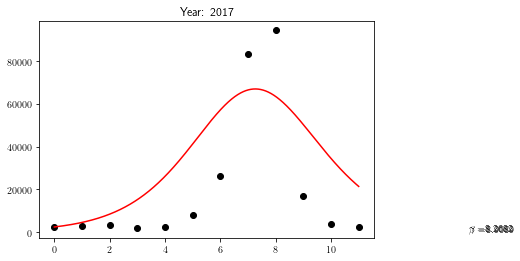

In [14]:
%matplotlib inline

plt.plot(t_range[:n_months.months+1], fluSeries[startdate:enddate].values,'ok',label="Original data")
plt.plot(t_eval,I,'-r',label="Infected fit")
plt.text(15, 60, r'$\gamma = $' + str(gamma))
plt.text(15, 64, r'$\beta = $' + str(beta))
plt.title("Year: " + str(year))
plt.savefig(imageDir + "fluIsolated/flu_" + str(year) + ".png" )
plt.show()